In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## Import data

In [2]:
# import data

sheet_id = '1U8h4VIgGR9kFQcrAAcAr5yoHK_VpcdjN4WP9kzlTp98'
sheet_name = 'logs_exp'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
data = pd.read_csv(url)

In [3]:
# the format for displaying numbers with two decimal places is set

pd.set_option('display.float_format', '{:.2f}'.format) 

In [4]:
# the first 5 rows of the dataframe

data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [5]:
print('Dataframe size:', data.shape)

Dataframe size: (4000, 14)


In [6]:
# basic information about the dataframe

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

## Data preprocessing

In [7]:
# renaming columns for convenience

data.rename(columns={'Month_to_end_contract': 'end_month', 
                     'Avg_additional_charges_total': 'avg_additional', 
                     'Avg_class_frequency_total': 'avg_visits_total', 
                     'Avg_class_frequency_current_month': 'avg_visits_current'}, 
            inplace=True)

In [8]:
# reducing the names of all columns to lowercase

data.columns = data.columns.str.lower()

In [9]:
# converting a column with the number of months to the int type

data['end_month'] = data['end_month'].astype(int)

In [10]:
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional,end_month,lifetime,avg_visits_total,avg_visits_current,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


In [11]:
print('Number of duplicates:', data.duplicated().sum())

Number of duplicates: 0


Missing data is not detected, categorical data is also missing

## Research data analysis

In [12]:
# information about columns containing non-binary data

data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
end_month,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


In [13]:
# grouping the aforementioned data to view averages

churn_groupby = data.groupby('churn')[['contract_period', 
                                       'age', 'avg_additional', 
                                       'end_month', 'lifetime', 
                                       'avg_visits_total', 
                                       'avg_visits_current']].mean()

churn_groupby

,contract_period,age,avg_additional,end_month,lifetime,avg_visits_total,avg_visits_current
churn,,,,,,,
0,5.75,29.98,158.45,5.28,4.71,2.02,2.03
1,1.73,26.99,115.08,1.66,0.99,1.47,1.04


In [14]:
# dictionary with decryption of column names

name_dict = {'churn':  'The fact of outflow in the current month',  
                    'gender':  'Clients gender',  
                    'near_location':  'Living or working in the area where the fitness center is located',  
                    'partner':  'Employee of the clubs partner company',  
                    'promo_friends':  'The fact of the initial recording within the framework of the "bring a friend" campaign',  
                    'phone':  'Availability of a contact phone number',  
                    'contract_period':  'Duration of the current valid subscription', 
                    'group_visits':  'The fact of attending group classes',  
                    'age':  'Clients age',  
                    'avg_additional':  'Total revenue from other services',  
                    'end_month':  'The period until the end of the current subscription',  
                    'lifetime':  'Time since the first visit to the fitness center',  
                    'avg_visits_total':  'Average frequency of visits per week for all time',  
                    'avg_visits_current':  'Average frequency of visits per week for the previous month'}
name_dict

{'churn': 'The fact of outflow in the current month',
 'gender': 'Clients gender',
 'near_location': 'Living or working in the area where the fitness center is located',
 'partner': 'Employee of the clubs partner company',
 'promo_friends': 'The fact of the initial recording within the framework of the "bring a friend" campaign',
 'phone': 'Availability of a contact phone number',
 'contract_period': 'Duration of the current valid subscription',
 'group_visits': 'The fact of attending group classes',
 'age': 'Clients age',
 'avg_additional': 'Total revenue from other services',
 'end_month': 'The period until the end of the current subscription',
 'lifetime': 'Time since the first visit to the fitness center',
 'avg_visits_total': 'Average frequency of visits per week for all time',
 'avg_visits_current': 'Average frequency of visits per week for the previous month'}

In [16]:
# correlation matrix

data_corr = data.corr()
data_corr

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional,end_month,lifetime,avg_visits_total,avg_visits_current,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
end_month,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


For a better visual perception of the correlation matrix, a heat map has been created:

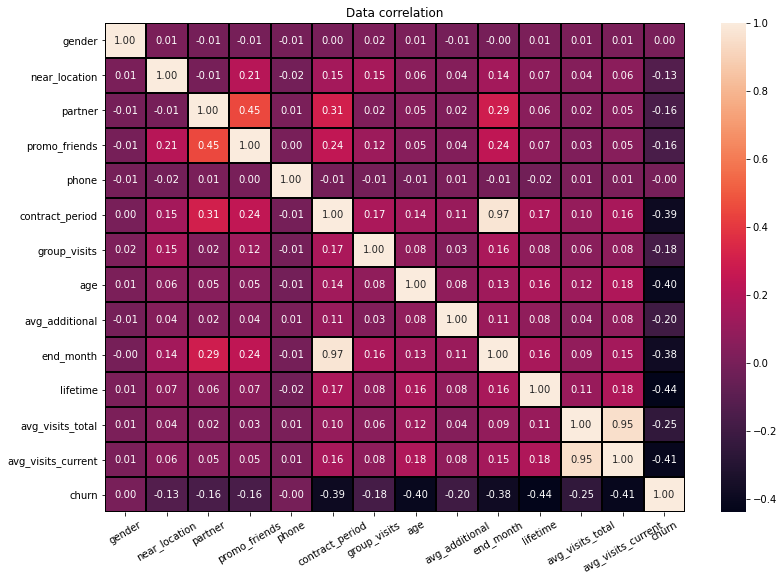

In [17]:
plt.figure(figsize=(13,9))
plt.title('Data correlation')
sns.heatmap(data_corr, annot = True, fmt='.2f', linewidths=1, linecolor='black')
plt.xticks(rotation = 30)
plt.show()

**Conclusion:**

The dataframe contains data of 4000 clients. Missing values, duplicates, and categorical variables are missing.

- gender: the average of the column is 0.51, we can conclude that the distribution by gender is approximately the same;
- near_location:the majority of clients (84.5%) live or work in the area where the fitness center is located;
- partner: approximately half (48.7%) of clients are employees of the club's partner company;
- promo_friends: only about 30% of customers came by the "Bring a friend" program;
- phone: approximately 90% of customers' mobile numbers are known;
- contract_period: more than half of the customers (55.2%) purchased a monthly subscription, 24% - for a year and 20.8% - for six months;
- group_visits: the majority (58.8%) have never attended group classes;
- age: the average age of customers is 29 years;
- avg_additional: on average, a visitor spends 136 yandex units for an additional.services center;
- end_month: the average period until the end of the contract is 4.3 months;
- lifetime: the average time since the first visit to the fitness center is 3.7 months;
- avg_visits_total: the average frequency of visits for all time is 1.87 times a week, only a small proportion of customers visit the gym more than 5 times a week;
- avg_visits_current: this month, the number of those who have not come to the gym once in a week has increased from 88 to 181;
- churn: in the current month, the outflow of customers amounted to 26.5%.


Users who have fallen into the outflow, almost all the average values of signs are lower than those who remained a client of the fitness fitness center. They are also united by criteria:
- the fitness center is far from home or work;
- are not employees of partner companies;
- they don't come by recommendation;
- do not attend group classes;
- purchase short-term subscriptions;
- spend less on additional services;
- they go to the gym less often;
- on average, 3 years younger than the remaining customers.

The histograms of the distribution confirm the conclusions:
- for the near_location attribute, the data are unevenly distributed. From this it can be assumed that mostly users choose a fitness room closer to home or work. Those for whom the hall is not located within walking distance often leave;
- employees of the club's partner companies stay more often than they leave;
- those who came on the recommendation of other clients are more likely to fall into the outflow of those.

The correlation matrix shows the greatest relationship with the target feature of such features as:
- lifetime;
- average attendance in the current month;
- age.

The subscription period and the number of months before the end of the subscription, the average weekly number of visits in general and in the current month also strongly correlate with each other, which is very logical.

## User churn prediction model

To predict the outflow of users, it is necessary to use binary classification. 

Binary classification is a special case of classification when there are only two classes: "0" or "1". 

In this case, the target variable contained in the 'churn' column is a binary value.

Models trained by algorithms for binary classification can not only predict the final value of a class for some object or client, but also estimate the probability of the event in question. A popular algorithm for solving such problems is **logistic regression**.

- The **model** variable will store the model;
- A set of **values of features X** and **the target variable y** is passed to the input of the model;
- The sample is divided into training and test using the **train_test_split()** method in the ratio of 80/20, observing the general rule: the training sample should be more delayed, but so that the test of metrics on the test remains valid. Added the **random_state** parameter, which is responsible for "randomness";
- To train the logistic regression model, the **Logistic Regression()** class was used, which also passed the random_state parameter;
- To start training, the **fit()** method is called. For training models, we pass a matrix with signs X and a vector with the values of the target variable y to the input;
- To make predictions for a data set, the **predict() method is called**

In [18]:
# the initial data is divided into features (matrix X) and target variable (y)

X = data.drop('churn', axis = 1)
y = data['churn']

# the model is divided into a training and validation sample

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [19]:
# algorithm for the model

model = LogisticRegression(random_state=0)

# training model

model.fit(X_train, y_train)

# making predictions

predictions = model.predict(X_test)

There will also be an attempt to solve the problem with the help of ensembles. They are powerful and allow you to reflect complex dependencies between data.

One of the main types of ensemble models is **random forest**. A decision tree will be used as a model. The choice of trees is not accidental. Unlike, for example, linear models, trees for each individual weak classifier can change not only subsamples of observations and features, but also other parameters. For example, limit the depth of the tree or the minimum number of objects in each node. Therefore, trees get much more models to solve the same problem.

The random forest algorithm generates many different trees that are independent of each other in slightly different ways (takes different subsamples, different features), and based on their answers forms the final solution. The random forest algorithm averages the responses of all trees (in the regression problem) or selects by vote (in the classification) the answer that most of the trees in the forest think is correct.

- To train the model, the RandomForestClassifier() class was used, which also passed the random_state parameter;
- When declaring the model, n_estimators = 100 is set (the number of trees on the basis of which the forest will be built);
- Other parameters of the tree, such as the depth of the tree (max_depth), the size of the subsample of features (max_features), the minimum number of objects in the node (min_samples_leaf) - by default.

In [20]:
# an algorithm for a new model based on the random forest algorithm is given

rf_model = RandomForestClassifier(random_state=0, n_estimators = 100)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

Since in the model the final predicted value takes the values 0 or 1, for each object the forecast belongs to one of four groups:

1) Model prediction = 1, real value = 1. Such forecasts are called True Positive (TP), "truly positive".

2) Model prediction = 1, real value = 0. Such forecasts are called False Positive (FP), "false positive".

3) Model prediction = 0, real value = 1. Such forecasts are called False Negative (FN), "false negative".

4) Model prediction = 0, real value = 0. Such forecasts are called True Negative (TN), "truly negative".

For a good model, most of the predictions should fall into the TP and TN groups.

- **The proportion of correct answers** - the metric **Accuracy** displays the proportion of correctly guessed answers from all predictions. The closer the accuracy value is to 100%, the better;
- To evaluate the model without reference to the ratio of classes, calculate metrics:
- **Precision** - shows which proportion of predictions about the "1" class is correct. In other words, it displays the proportion of correct answers only among the target class;
- **Recall** shows how many real objects of class "1" could be detected using a model aimed at minimizing the opposite risks

In [21]:
# a function that will output metrics

def metrics(y_true, y_pred, title='Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
metrics(y_test, predictions, title='Metrics for a linear regression model:')

metrics(y_test, rf_predictions, title='Metrics for the random forest model:')

Metrics for a linear regression model:
	Accuracy: 0.92
	Precision: 0.87
	Recall: 0.80
Metrics for the random forest model:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


**Conclusion:**

The linear regression model shows itself better, because all the metrics studied are slightly, but higher than that of the random forest model

## Clustering of users

Since the customer base is non-uniform, clustering will help to break it into segments. It will help to identify user segments and, for example, offer each segment a suitable product option.

- It is necessary to bring the features to a single scale using **standardization**, which will bring the values of the features to the form of a standard normal distribution: the values will be centered relative to 0, and the average spread of the data will be 1;
- - In **X_sc** using the **hit_transform()** method, the transformed feature object table for the training and validation set will get into, which will be used for training and forecasting;
- After that, standardization is performed and the resulting standardized table is passed as a parameter of the **linkage()** function. In order for the diagram to be indicative, it is better to pass the 'ward' value to the method parameter

In [22]:
# deleting a column with a target variable

data_cluster = data.drop('churn', axis = 1)

# standardization of data

sc = StandardScaler()
X_sc = sc.fit_transform(data_cluster)

# distance matrix on a standardized feature matrix

linked = linkage(X_sc, method = 'ward')

A table of "bundles" between objects is stored in the linked variable. Visualizing it as a dendrogram:

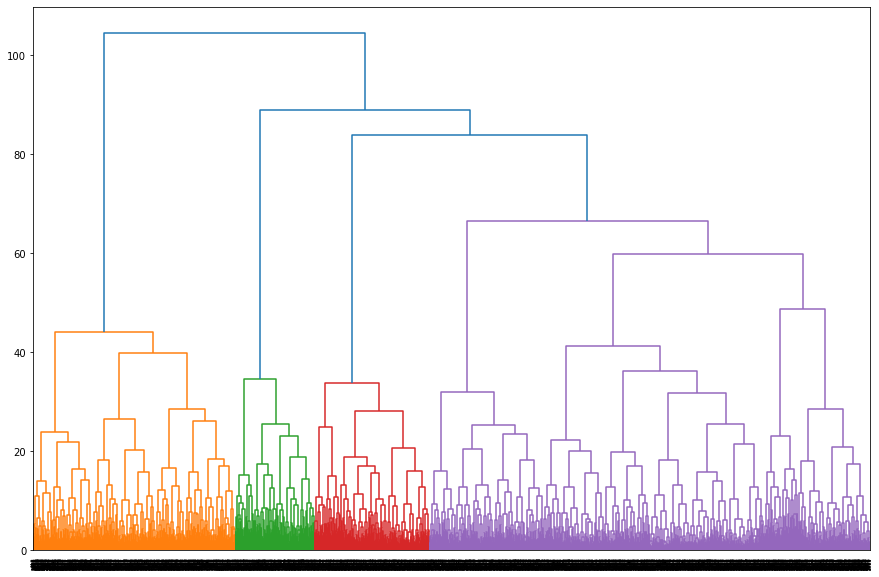

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

The proposed optimal number of clusters is 4.

The complexity of agglomerative clustering lies not in the structure of the algorithm itself, but in the calculations that are performed to build a dendrogram. Calculations of pairwise distances can take a very long time. Therefore, when solving the clustering problem, it is useful to build a dendrogram on a random subsample, and after evaluating the optimal number of clusters, run a faster K-Means algorithm.

**K-means** is one of the popular clustering algorithms. The algorithm is based on the assumption that the number of clusters is known in advance. 

The principle of operation of the step-by-step K-means algorithm:

1) There are K clusters. The algorithm selects their centers step by step and assigns objects to the cluster whose center is closer.

2) The centers are adjusted (change their position) as long as it allows minimizing the average distance from the objects of each cluster to its center.

3) When the distance from the objects to the center ceases to decrease or decreases insignificantly, the algorithm stops and fixes the partition, considering it optimal.

An algorithm has been applied to the data and a cluster vector has been formed, data standardization has already been performed earlier in the variable X_sc

In [24]:
# the number of clusters equal to 5

km = KMeans(n_clusters = 5, random_state = 0) 

# indexes of the proposed group algorithms are stored in the labels variable

labels = km.fit_predict(X_sc) 

In [25]:
# saved cluster labels in the dataframe field

data_cluster['cluster'] = labels

In [26]:
# statistics on the average values of features by cluster

data_cluster.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional,160.76,143.96,135.46,131.62,161.66
end_month,9.95,4.48,2.20,1.86,2.46


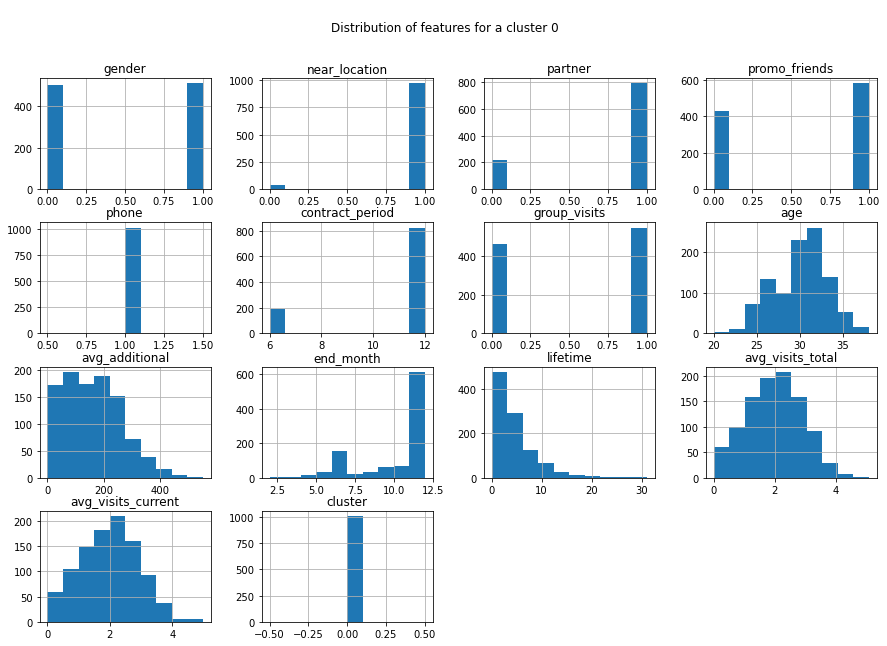

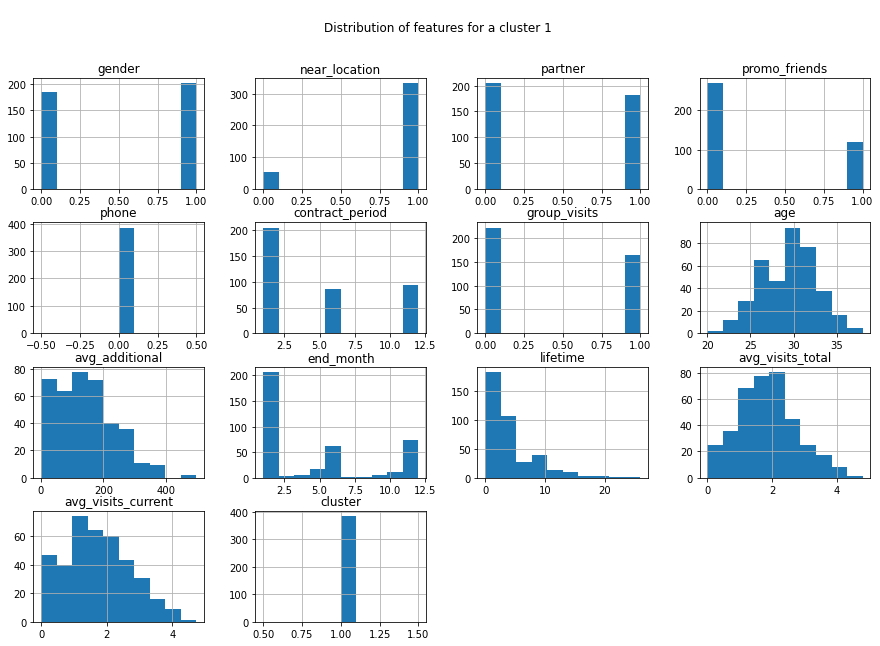

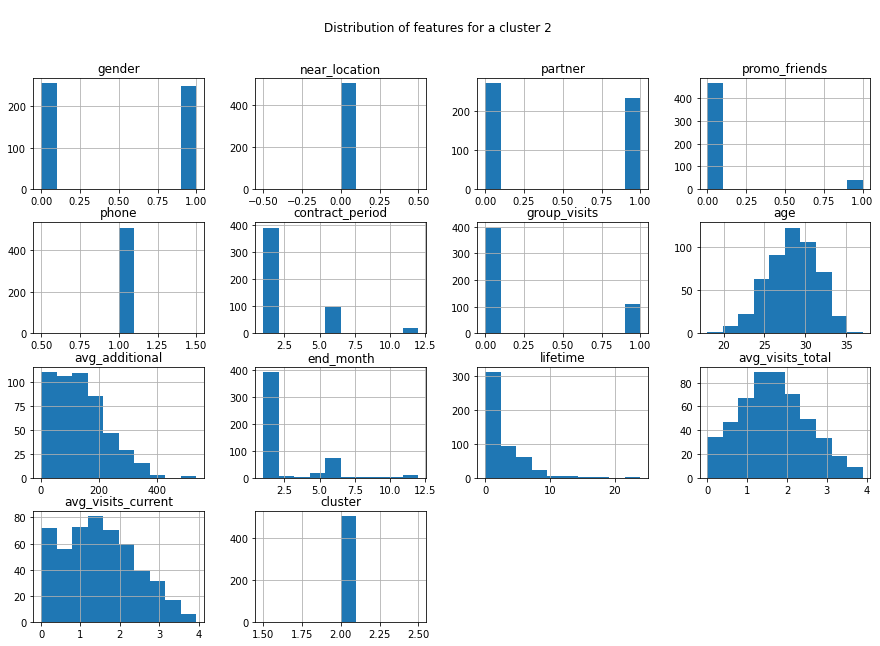

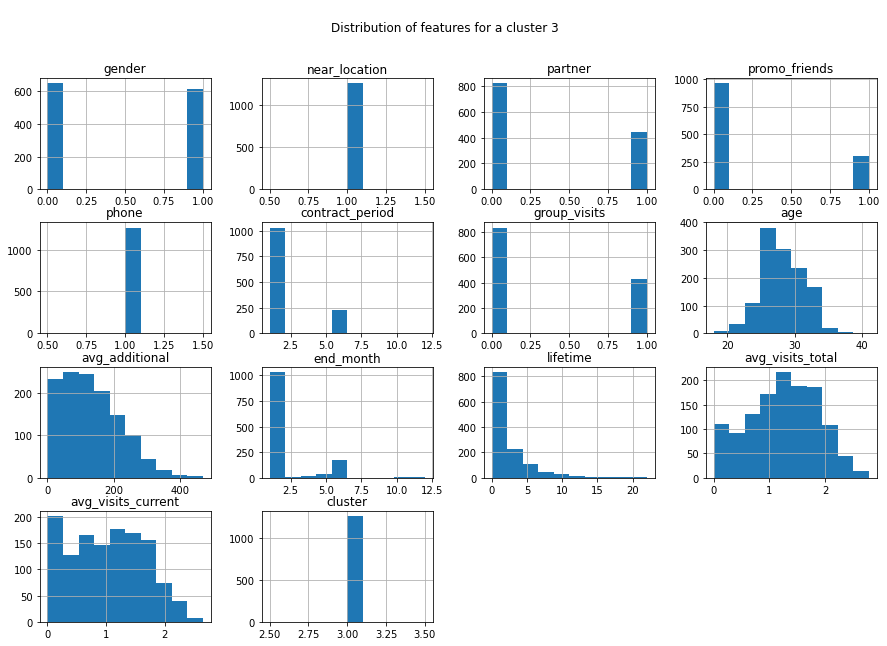

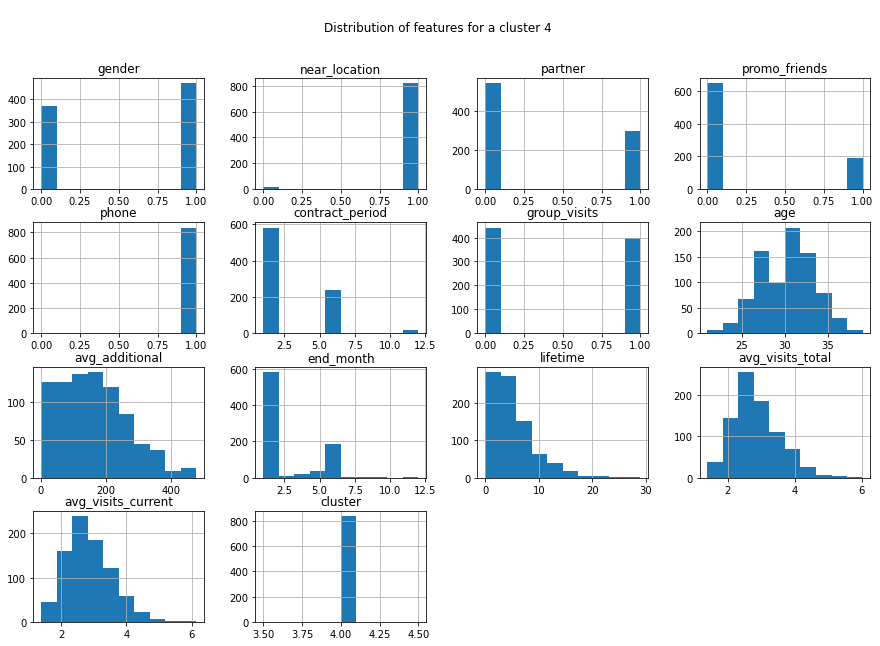

In [27]:
for value in [0, 1, 2, 3, 4]:
    data_cluster[data_cluster['cluster']==value].hist(figsize=(15,10))
    plt.suptitle('\nDistribution of features for a cluster {}'.format(value))
    plt.show();

In [28]:
# adding cluster values to the source dataset

data['cluster'] = labels

For each cluster, the total number of clients and the number of clients who have fallen into the outflow are calculated

In [29]:
# the outflow coefficient is calculated

clusters = data.groupby('cluster', as_index=False).agg({'churn':['count', 'sum']})
clusters.columns = [' '.join(col).strip() for col in clusters.columns.values]
clusters.rename(columns={'churn count':'total', 'churn sum':'churn'}, inplace=True)
clusters['churn_rate'] = round(clusters['churn'] / clusters['total'], 2)
clusters.sort_values(by='churn_rate', ascending=False)

,cluster,total,churn,churn_rate
3,3,1262,649,0.51
2,2,505,224,0.44
1,1,385,103,0.27
4,4,838,57,0.07
0,0,1010,28,0.03


**Conclusion:**

- Cluster 2 clients do not live or work close to the fitness center;
- In each cluster, at least a third of customers are employees of the club's partner company;
- The smallest share of customers who came through the "Bring a friend" promo campaign is in cluster 2;
- Fitness center clients from the first cluster did not provide a contact phone number;
- The highest average duration of the current subscription and the amount of expenses for additional services of the club for users from cluster 1;
- From 22% to 54% of clients in all clusters attend group classes, the least of such users in cluster 2;
- The time from the moment of the first visit to the fitness center is on average from 2.5 to almost 5 months;
- The average frequency of visits per week since the beginning of the subscription and for all time is almost the same in all clusters except 2 and 3: in them it decreased from 1.66 to 1.48 and from 1.25 to 1.01, respectively.

Cluster 3 and 2 clients are the most prone to outflow (51% and 44%, respectively), cluster 0 and 4 clients are the most loyal. 

It should be noted that clusters 0 and 3 have the largest number of clients.

## General conclusion

In the course of this research, information about 4000 fitness center clients was studied, models for predicting user outflow were built and a clustering model was implemented.

As a result of the research, the following patterns were revealed for users who ceased to be customers of the fitness center in the current month:

- they live or work far from the fitness center, i.e. the walking accessibility of the gym is important for customers, they do not want to waste extra time on the road;
- they are not employees of partner companies, in other words, there is no discount for them on a subscription from the employer;
- they do not come on the recommendation of friends who have become clients of the fitness center;
- rarely attend group classes;
- most often they purchase short-term season tickets, perhaps they want to understand whether they are ready to visit this club;
- spend less on other fitness center services, such as cafes, sports goods, beauty or massage parlors;
- they go to the gym less often;
- the average age is 3 years less than the remaining users.

When predicting the outflow of customers next month, the logistic regression model performed best - the values of the accuracy, precision and recall metrics were higher than those calculated using the random forest model. It can be concluded that the model is reliable, i.e. the values of the metrics are quite high.

Clustering was also performed, as a result of which it was revealed that customers of cluster 3 and 2 are most prone to outflow (51% and 44%, respectively), customers of cluster 0 and 4 are the most loyal.

**Recommendations:**

The average subscription period for cluster 3 clients is 1 month, i.e. probably such clients should not be considered as potentially permanent. Such a subscription period may indicate that a person wants to try to start playing sports in general, they rarely go to the gym, it is likely that their outflow is associated with a lack of motivation. For clients from this cluster, you can offer a discount on additional fitness center services to expand their understanding of the services provided at the club. It can also be effective to offer a subscription extension on more favorable terms, the "regular customer" program, when when buying subscriptions without a break, the client is offered a good discount

More loyal customers live or work closer to the fitness center, so an advertising campaign aimed at residents of nearby houses or the conclusion of favorable contracts with employers located within walking distance can bring a lot of new customers for whom minimal outflow is expected.

It is worth paying attention to informing the current, as well as potential clients of the fitness center about the availability of group classes, to focus on the fact that it will be more effective for beginners, because classes will be held under the supervision of a coach. In extreme cases, you can revise the format, time, or pay attention to the pre-sponsors of group classes, because their attendance is not large enough.